Convert train_curated.csv to target vectors.

Create train_curated matrix which contains lmfccs of each audio file.

Define function which randomly slices chunck of audio or zero-pads it to reach required size.

Create and train CNN.

Create histogram of file sizes. Create separate histogram for n=[1,2,3..] where n = number of labels per file. (Want to see if files with more labels tend to be longer).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv

import os
# from keras.utils import np_utils

import librosa

Using TensorFlow backend.


In [110]:
#  conda install -c conda-forge librosa 

Path from this file to dir with train_curated/ and train_curated.csv

In [3]:
raw_data_path = '../../raw_data/'
transformed_data_path = '../../transformed_data/'

Hard code list of labels so we don't accidentally reorder them later. Index of label in this list will correspond to index with value 1 in a target vector.

In [4]:
labels_list = ['Bark', 'Raindrop', 'Finger_snapping', 'Run', 'Whispering', 'Acoustic_guitar', 'Strum', 'Hi-hat', 'Bass_drum', 'Crowd', 'Cheering', 'Frying_(food)', 'Chewing_and_mastication', 'Fart', 'Bass_guitar', 'Knock', 'Motorcycle', 'Stream', 'Male_singing', 'Crackle', 'Sigh', 'Burping_and_eructation', 'Female_singing', 'Tap', 'Female_speech_and_woman_speaking', 'Accelerating_and_revving_and_vroom', 'Clapping', 'Accordion', 'Zipper_(clothing)', 'Bus', 'Meow', 'Waves_and_surf', 'Microwave_oven', 'Child_speech_and_kid_speaking', 'Buzz', 'Car_passing_by', 'Toilet_flush', 'Purr', 'Church_bell', 'Electric_guitar', 'Marimba_and_xylophone', 'Trickle_and_dribble', 'Traffic_noise_and_roadway_noise', 'Harmonica', 'Male_speech_and_man_speaking', 'Slam', 'Keys_jangling', 'Sink_(filling_or_washing)', 'Water_tap_and_faucet', 'Squeak', 'Cricket', 'Fill_(with_liquid)', 'Skateboard', 'Shatter', 'Drawer_open_or_close', 'Race_car_and_auto_racing', 'Cupboard_open_or_close', 'Computer_keyboard', 'Writing', 'Sneeze', 'Drip', 'Bicycle_bell', 'Applause', 'Printer', 'Gong', 'Glockenspiel', 'Screaming', 'Yell', 'Cutlery_and_silverware', 'Walk_and_footsteps', 'Mechanical_fan', 'Gasp', 'Gurgling', 'Chink_and_clink', 'Tick-tock', 'Chirp_and_tweet', 'Hiss', 'Dishes_and_pots_and_pans', 'Bathtub_(filling_or_washing)', 'Scissors']

Generate list of labels:

In [11]:
# labels = []
# with open('../../train_curated.csv') as csvDataFile:
#     csvReader = csv.reader(csvDataFile)
#     for row in csvReader:
#         if row[0] == 'fname':
#             continue
#         curr_labels = row[1].split(',')
#         for label in curr_labels:
#             if label not in labels:
#                 labels.append(label)

Map filenames to label vector:

In [10]:
filenames_to_labels = {}
with open(raw_data_path + 'train_curated.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        # ignore first row
        if row[0] == 'fname':
            continue
        # map filename to label vector coresponding to that file
        filename = row[0]
        label_vector = [0] * len(labels_list)
        curr_labels = row[1].split(',')
        for l in curr_labels:
            label_vector[labels_list.index(l)] = 1
        filenames_to_labels[filename] = label_vector   

In [139]:
# # np_utils.to_categorical(targets, output_dim))
# filenames_to_labels = {}
# with open(raw_data_path + 'train_curated.csv') as csvDataFile:
#     csvReader = csv.reader(csvDataFile)
#     for row in csvReader:
#         # ignore first row
#         if row[0] == 'fname':
#             continue
#         # map filename to label vector coresponding to that file
#         filename = row[0]
# #         label_vector = [0] * len(labels_list)
#         curr_labels = row[1].split(',')
#         curr_labels_indicies = []       
#         for l in curr_labels:
#             curr_labels_indicies.append(labels_list.index(l))
#         filenames_to_labels[filename] = np_utils.to_categorical(curr_labels_indicies, len(labels_list))

In [7]:
# filenames_to_labels

Use librosa to generate spectrograms:

In [26]:
file_path = raw_data_path + 'train_curated/3b1a1a3d.wav'
samples, sr = librosa.load(file_path, sr=44100, mono=True)
# samples = samples[np.newaxis]
print(samples, sr)
print(len(samples))

[0.00079346 0.00079346 0.0017395  ... 0.00344849 0.00415039 0.00393677] 44100
334122


../../sox-14.4.2/sox ../../raw_data/train_curated/0b8c8a7f.wav tmp2.wav norm -0.1 silence 1 0.025 0.15% norm -0.1 reverse silence 1 0.025 0.15% reverse

In [16]:
file = '../../raw_data/train_curated/e6deee64.wav'
aug_cmd = "norm -0.1 silence 1 0.025 0.15% norm -0.1 reverse silence 1 0.025 0.15% reverse"
aug_audio_file = "⁨⁩tmp_ee.wav"
os.system("../../sox-14.4.2/sox %s %s %s" % (file, aug_audio_file, aug_cmd))

assert os.path.exists(aug_audio_file), "SOX Problem ... clipped wav does not exist!"

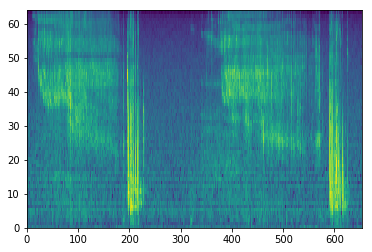

(653, 64)

In [37]:
n_fft=1024
sr=44100
mono=True
log_spec=False
n_mels=64
hop_length=512
fmax=None

# Compute stft
stft = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann', center=True,
                    pad_mode='reflect')

# Get only frequencies and ignore phases.
stft = np.abs(stft)

# Select our spectrogram weighting.
if log_spec:
    stft = np.log10(stft + 1)
else:
    freqs = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)
    stft = librosa.perceptual_weighting(stft ** 2, freqs, ref=1.0, amin=1e-10, top_db=99.0)

# Apply mel filterbank.
spectrogram = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels, fmax=fmax).T

plt.pcolormesh(np.asarray(spectrogram.T))
plt.show()
assert spectrogram.shape[1] == n_mels
spectrogram.shape

In [42]:
np.max(spectrogram)

0.3275945033902808

In [49]:
train_chunks = np.load('../../chunked_data/train_main_chunks.npy')
train_chunks.shape
test_chunks = np.load('../../chunked_data/test_chunks.npy')
test_chunks.shape

(1, 5, 128, 64)

Make histogram of audio lengths in data set. (seconds x n)

In [29]:
lengths = []
sample_rate = 44100
i = 0
for root, dirs, files in os.walk(raw_data_path + 'train_curated'):
    for file in files:
        i = i + 1
        print("\r", str(i) + ' ' + file, end="")
        file_path = os.path.join(root, file)
        samples, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        len_seconds = len(samples) / sample_rate
        lengths.append(len_seconds)
        

 4970 7eb4d9f0.wav

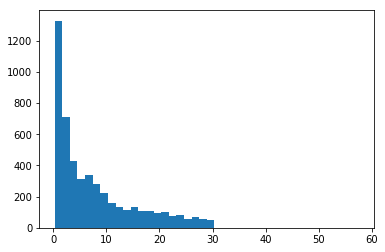

In [36]:
plt.hist(lengths, 40)
plt.show()

In [144]:
temp = np.load(transformed_data_path + 'cab5c701_spectrogram.npy')

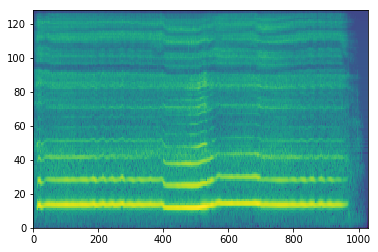

In [145]:
plt.pcolormesh(temp)
plt.show()

In [11]:
# Input spectrogram should be n X f where n is time domain and f is size of filterbank (128)
def spectrogram_to_chunks(spectrogram, chunk_size=256):
    chunks = []
    if spectrogram.shape[0] < chunk_size:
        # Spectrogram is small, pad it.
        padding = np.full((chunk_size - spectrogram.shape[0], spectrogram.shape[1]), np.min(spectrogram))
        chunks.append(np.concatenate((spectrogram, padding)))
    else:
        i = 0
        while(spectrogram.shape[0] - i >= chunk_size):
            chunks.append(spectrogram[i:i + chunk_size])
            i += chunk_size
    return chunks

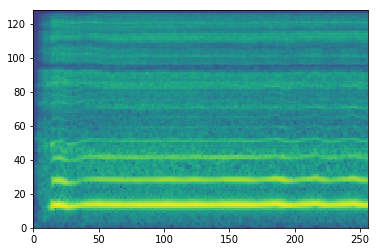

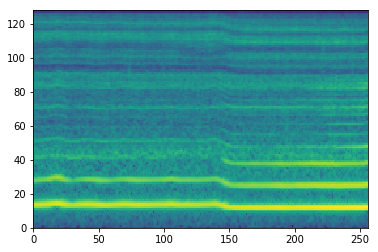

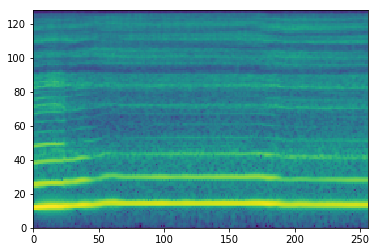

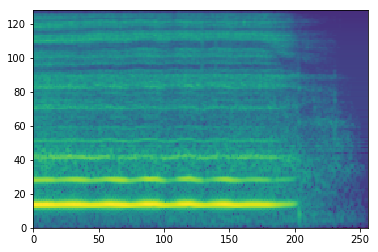

In [151]:
chunks = spectrogram_to_chunks(temp.T)
for chunk in chunks:
    plt.pcolormesh(chunk.T)
    plt.show()

In [5]:
import numpy as np
a = [1, 2, 3]
b = [5, 1, 1]
c = [0, 8, 1]
d = []
d.append(a)
d.append(b)
d.append(c)
np.max(d, axis=0)

array([5, 8, 3])

In [6]:
[1, 2] + [3]

[1, 2, 3]